# Import libraries and data

In [1]:
# Import the libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from numpy import percentile
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)



In [2]:
!pip install pyod

     |████████████████████████████████| 102kB 3.4MB/s 
  Created wheel for pyod: filename=pyod-0.8.7-cp37-none-any.whl size=115979 sha256=62ee57e7c23af360931fc62889afe4f06326793b7b4e313e2ce7c01517119984
  Stored in directory: /root/.cache/pip/wheels/b7/8a/c9/5fe3f32692ad445fe573cf5b953d7a0d55dc1f7c8e229ebda0
Successfully built pyod


In [3]:
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/cocrystal_design/utils/')
from pu_learning import spies

Mounted at /content/drive


In [4]:
X = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/X_to_PU_Performance.csv")
y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/y_to_PU_Performance.csv")
X = X.iloc[:,1:]
y = y.iloc[:,1:]
X = X.squeeze('columns')
y = y.squeeze('columns')

In [5]:
# Shuffle dataset
print("Shuffling dataset....")
permut = np.random.permutation(len(y))
X = X.reindex(permut)
y = y.reindex(permut)

Shuffling dataset....


In [6]:
print("Loaded {} examples.".format(len(y)))
print("{} are unlabelled.".format(len(np.where(y == 0.)[0])))
print("{} are postive.".format(len(np.where(y == +1)[0])))


Loaded 49304 examples.
45582 are unlabelled.
3722 are postive.


# Evaluate the One class models

In [ ]:
# Calculate the learning curves of the Ensemble

from sklearn.model_selection import learning_curve
from pyod.models.iforest import IForest
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score


X = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/X_to_PU_Performance.csv")
y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/y_to_PU_Performance.csv")
X = X.iloc[:,1:]
y = y.iloc[:,1:]
X = X.squeeze('columns')
y = y.squeeze('columns')

X_train=X.iloc[:3000, :]
y=np.zeros(X_train.shape[0])
classifiers =  IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000, random_state=0)
 

scoring = make_scorer(accuracy_score)
train_sizes=np.linspace(.02, 1.0, 25)

train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(classifiers, X_train, y ,cv = 5, scoring = scoring ,train_sizes=train_sizes, 
                       random_state= 0, return_times=True)
      
train_scores_mean_ens = np.mean(train_scores, axis=1)
train_scores_std_ens = np.std(train_scores, axis=1)
test_scores_mean_ens = np.mean(test_scores, axis=1)
test_scores_std_ens = np.std(test_scores, axis=1)

print(train_sizes)
print(test_scores_mean_ens)
test_scores_std_ens



[  48  146  244  341  439  538  636  734  832  930 1028 1126 1224 1322
 1420 1518 1616 1713 1812 1910 2008 2106 2204 2302 2400]
[0.39       0.80066667 0.76266667 0.76966667 0.738      0.697
 0.68166667 0.749      0.843      0.85       0.82566667 0.84166667
 0.86433333 0.901      0.898      0.89766667 0.89333333 0.88166667
 0.89566667 0.90633333 0.905      0.902      0.902      0.89966667
 0.90033333]


array([0.19795342, 0.16696507, 0.08909795, 0.11682085, 0.12792098,
       0.14928496, 0.16185728, 0.18951576, 0.11162138, 0.08944272,
       0.10448073, 0.10972187, 0.0958158 , 0.07558365, 0.08304885,
       0.0810665 , 0.08787618, 0.09604976, 0.07301902, 0.07146405,
       0.07093816, 0.0754203 , 0.07876406, 0.08411896, 0.08754301])

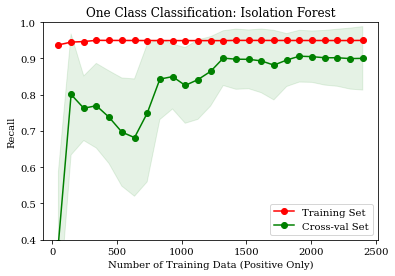

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.ylim((0.4,1))
plt.title("One Class Classification: Isolation Forest")
plt.xlabel('Number of Training Data (Positive Only)')
plt.ylabel('Recall')
plt.fill_between(train_sizes,train_scores_mean_ens-train_scores_std_ens,
                  train_scores_mean_ens+train_scores_std_ens,alpha=0.1,color='r')
plt.fill_between(train_sizes,test_scores_mean_ens-test_scores_std_ens,
                  test_scores_mean_ens+test_scores_std_ens,alpha=0.1,color='g')
plt.plot(train_sizes,train_scores_mean_ens,'o-',color='r',label='Training Set')
plt.plot(train_sizes,test_scores_mean_ens,'o-',color='g',label='Cross-val Set')
plt.legend(loc='best')
plt.savefig(fname='Recall_IForest.png',dpi=400, bbox_inches = 'tight')

# Evaluate the PU models

In [ ]:
import numpy as np
import logging


logger = logging.getLogger(__name__)

class spies:
    """
    PU spies method, based on Liu, Bing, et al. "Partially supervised classification of
    text documents." ICML. Vol. 2. 2002.
    """
    def __init__(self, first_model, second_model):
        """
        Any two models which have methods fit, predict and predict_proba can be passed,
        for example" `spies(XGBClassifier(), XGBClassifier())`
        """
        self.first_model = first_model
        self.second_model = second_model
        
    def fit(self, X, y, spie_rate=0.2, spie_tolerance=0.05):
        """
        Trains models using spies method using training set (X, y).

        Parameters
        ----------
        X : {array-like} of shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples]
            The target values (1 for positive, 0 for unlabeled).
            
        spie_rate : {float} = 0.2 (default)
            Determines percentage of spies which will be included when training first model.
            
        spie_tolerance : {float} = 0.05 (default)
            Determines tolerated percentage of spies which can come from the first model.
            Using this tolerance threshold is chosen which splits dataset into Likely negative
            and unlabeled groups.

        Returns
        -------
        self : object
            Returns self.
        """
        np.random.seed(42)
        # Step 1. Infuse spies
        spie_mask = np.random.random(y.sum()) < spie_rate
        # Unknown mix + spies
        MS = np.vstack([X[y == 0], X[y == 1][spie_mask]])
        MS_spies = np.hstack([np.zeros((y == 0).sum()), np.ones(spie_mask.sum())])
        # Positive with spies removed
        P = X[y == 1][~spie_mask].values
        # Combo
        MSP = np.vstack([MS, P])
        # Labels
        MSP_y = np.hstack([np.zeros(MS.shape[0]), np.ones(P.shape[0])])
        # Fit first model
        logger.debug('Training first model')
        self.first_model.fit(MSP, MSP_y)
        prob = self.first_model.predict_proba(MS)[:, 1]
        # Find optimal t
        t = 0.001
        while MS_spies[prob <= t].sum()/MS_spies.sum() <= spie_tolerance:
            t += 0.001
        logger.debug('Optimal t is {0:.06}'.format(t))
        logger.debug('Positive group size {1}, captured spies {0:.02%}'.format(
            MS_spies[prob > t].sum()/MS_spies.sum(), (prob > t).sum()))
        logger.debug('Likely negative group size {1}, captured spies {0:.02%}'.format(
            MS_spies[prob <= t].sum()/MS_spies.sum(), (prob <= t).sum()))
        # likely negative group
        N = MS[(MS_spies == 0) & (prob <= t)]
        
       
        P = X[y == 1]
        NP = np.vstack([N, P])



        L = np.hstack([np.zeros(N.shape[0]), np.ones(P.shape[0])])

      
        # Fit second model
        logger.debug('Training second model')
        self.second_model.fit(NP, L)
        
    def predict(self, X):
        """
        Predicts classes for X. Uses second trained model from self.

        Parameters
        ----------
        X : {array-like} of shape = [n_samples, n_features]
            The training input samples.

        Returns
        -------
        y : array of shape = [n_samples]
            The predicted classes.
        """
        return self.second_model.predict(np.array(X))
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X. Uses second trained model from self.

        Parameters
        ----------
        X : {array-like} of shape = [n_samples, n_features]
            The training input samples.

        Returns
        -------
        p : array of shape = [n_samples, n_classes]
            The class probabilities of the input samples.
        """
        return self.second_model.predict_proba(np.array(X))[:,1]

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
class PU_Classifier(BaseEstimator, ClassifierMixin):
    """
    PU spies method, based on Liu, Bing, et al. "Partially supervised classification of
    text documents." ICML. Vol. 2. 2002.
    """
    def __init__(self, first_model, second_model):
        """
        Any two models which have methods fit, predict and predict_proba can be passed,
        for example" `spies(XGBClassifier(), XGBClassifier())`
        """
        self.first_model = first_model
        self.second_model = second_model
        
    def fit(self, X, y, spie_rate=0.2, spie_tolerance=0.05):
        """
        Trains models using spies method using training set (X, y).

        Parameters
        ----------
        X : {array-like} of shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples]
            The target values (1 for positive, 0 for unlabeled).
            
        spie_rate : {float} = 0.2 (default)
            Determines percentage of spies which will be included when training first model.
            
        spie_tolerance : {float} = 0.05 (default)
            Determines tolerated percentage of spies which can come from the first model.
            Using this tolerance threshold is chosen which splits dataset into Likely negative
            and unlabeled groups.

        Returns
        -------
        self : object
            Returns self.
        """
        np.random.seed(42)
        # Step 1. Infuse spies
        spie_mask = np.random.random(y.sum()) < spie_rate
        # Unknown mix + spies
        MS = np.vstack([X[y == 0], X[y == 1][spie_mask]])
        MS_spies = np.hstack([np.zeros((y == 0).sum()), np.ones(spie_mask.sum())])
        # Positive with spies removed
        P = X[y == 1][~spie_mask].values
        # Combo
        MSP = np.vstack([MS, P])
        # Labels
        MSP_y = np.hstack([np.zeros(MS.shape[0]), np.ones(P.shape[0])])
        # Fit first model
        logger.debug('Training first model')
        self.first_model.fit(MSP, MSP_y)
        prob = self.first_model.predict_proba(MS)[:, 1]
        # Find optimal t
        t = 0.001
        while MS_spies[prob <= t].sum()/MS_spies.sum() <= spie_tolerance:
            t += 0.001
        logger.debug('Optimal t is {0:.06}'.format(t))
        logger.debug('Positive group size {1}, captured spies {0:.02%}'.format(
            MS_spies[prob > t].sum()/MS_spies.sum(), (prob > t).sum()))
        logger.debug('Likely negative group size {1}, captured spies {0:.02%}'.format(
            MS_spies[prob <= t].sum()/MS_spies.sum(), (prob <= t).sum()))
        # likely negative group
        N = MS[(MS_spies == 0) & (prob <= t)]
        
       
        P = X[y == 1]
        NP = np.vstack([N, P])



        L = np.hstack([np.zeros(N.shape[0]), np.ones(P.shape[0])])

      
        # Fit second model
        logger.debug('Training second model')
        self.second_model.fit(NP, L)
        
    def predict(self, X):
        """
        Predicts classes for X. Uses second trained model from self.

        Parameters
        ----------
        X : {array-like} of shape = [n_samples, n_features]
            The training input samples.

        Returns
        -------
        y : array of shape = [n_samples]
            The predicted classes.
        """
        return self.second_model.predict(np.array(X))
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X. Uses second trained model from self.

        Parameters
        ----------
        X : {array-like} of shape = [n_samples, n_features]
            The training input samples.

        Returns
        -------
        p : array of shape = [n_samples, n_classes]
            The class probabilities of the input samples.
        """
        return self.second_model.predict_proba(np.array(X))[:,1] 



In [7]:

def plot_learning_curve(estimator,x,y,cv=None,train_size = np.linspace(0.1,1.0,5),plt_size =None):

    from sklearn.model_selection import learning_curve
    train_sizes,train_scores,test_scores = learning_curve(estimator=estimator,
                                                          X=x,
                                                          y=y,
                                                          cv=cv,
                                                          scoring = 'recall',
                                                          n_jobs=-1,
                                                          train_sizes=train_size)
    # train_sizes = train_sizes/16
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores,axis=1)
    plt.figure(figsize=plt_size)
    plt.title("Two-step PU Learning")
    plt.xlabel('Number of Training Data')
    plt.ylabel('Recall')
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,
                     train_scores_mean+train_scores_std,alpha=0.1,color='r')
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std,
                     test_scores_mean+test_scores_std,alpha=0.1,color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color='r',label='Training Set')
    plt.plot(train_sizes,test_scores_mean,'o-',color='g',label='Cross-val Set')
    plt.legend(loc='best')
    plt.savefig(fname='Recall_PU.png',dpi=400, bbox_inches = 'tight')
    return plt.show()

Shuffling dataset....


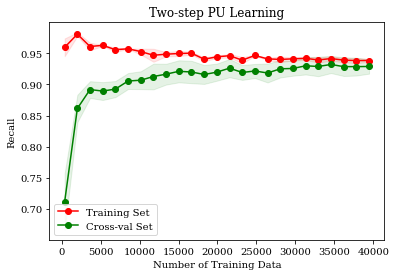

In [ ]:
# model_copy = spies(RandomForestClassifier(n_estimators=200,max_depth =  None, oob_score = True,  class_weight = 'balanced', n_jobs = -1,random_state=0),RandomForestClassifier(n_estimators=200,max_depth =  5, oob_score = True,  class_weight = 'balanced_subsample', n_jobs = -1,random_state=0))
# model_copy.fit(X, y,spie_rate=0.1, spie_tolerance=0.1)


# RandomForestClassifier(n_estimators=200,max_depth =  5, oob_score = True,  class_weight = 'balanced_subsample', n_jobs = -1,random_state=0)

# Shuffle dataset
print("Shuffling dataset....")
permut = np.random.permutation(len(y))

# Must reindex
# X = X.reindex(permut)
# y = y.reindex(permut)


spy =  PU_Classifier(RandomForestClassifier(n_estimators=20,max_depth =  7, oob_score = True,  class_weight = 'balanced', n_jobs = -1,random_state=0),RandomForestClassifier(n_estimators=20,max_depth =  5, oob_score = True,  class_weight = 'balanced_subsample', n_jobs = -1,random_state=0))
 

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plot_learning_curve(spy,X,y,cv=5,train_size = np.linspace(0.01,1,25),plt_size =None)


# Evaluate the traditional binary classification models

In [11]:

def plot_learning_curve(estimator,x,y,cv=None,train_size = np.linspace(0.1,1.0,5),plt_size =None):

    from sklearn.model_selection import learning_curve
    train_sizes,train_scores,test_scores = learning_curve(estimator=estimator,
                                                          X=x,
                                                          y=y,
                                                          cv=cv,
                                                          scoring = 'recall',
                                                          n_jobs=-1,
                                                          train_sizes=train_size)
    # train_sizes = train_sizes/16
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores,axis=1)
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

    plt.figure(figsize=plt_size)
    plt.title("Traditional Binary Classification")
    plt.xlabel('Number of Training Data')
    plt.ylabel('Recall')
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,
                     train_scores_mean+train_scores_std,alpha=0.1,color='r')
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std,
                     test_scores_mean+test_scores_std,alpha=0.1,color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color='r',label='Training Set')
    plt.plot(train_sizes,test_scores_mean,'o-',color='g',label='Cross-val Set')
    plt.legend(loc='best')
    plt.savefig(fname='Recall_trad.png',dpi=400, bbox_inches = 'tight')
    return plt.show()

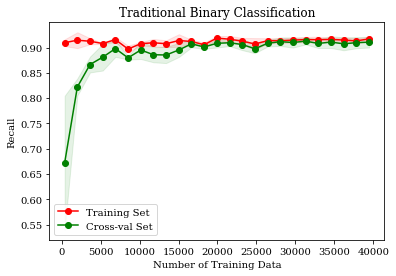

In [12]:
RF = RandomForestClassifier(n_estimators=10,max_depth =  4, oob_score = True,  class_weight = 'balanced', n_jobs = -1,random_state=0)
plot_learning_curve(RF,X,y,cv=5,train_size = np.linspace(0.01,1,25),plt_size =None)